# ⋆. 𐙚 ̊ FANtastic Trio Member  ̊ 𐙚⋆.

*   นางสาวมณิสรา แซ่จัน รหัสนิสิต 66102010151
*   นายฐิติวัฒน์ ฮาบสุวรรณ รหัสนิสิต 66102010238
*   นางสาวเอมี่หลุยส์ บราวน์ รหัสนิสิต 66102010572

**Flowchart กระบวนการทำงานทั้งหมด**

<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=10WKavSgAR8NRqYP2RdOIHZRojwW0XK5g" height="400">
</div>

# Connecting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installation & Import Libraries

In [ ]:
!pip install ultralytics mediapipe roboflow

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


# Load Yoga Dataset

โหลดชุดข้อมูลจาก Roboflow: [Yoga Dataset](https://universe.roboflow.com/spguj/yoga-26dw7/dataset/1)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="ขออนุญาตเอา API ออก")
project = rf.workspace("spguj").project("yoga-26dw7")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Yoga-1 in yolov11:: 100%|██████████| 3248/3248 [00:00<00:00, 6919.65it/s]


# ˖⋆˚✿˖° Section 1: Training YOLO11 Pose Classifier

In [ ]:
!yolo detect train data=/content/Yoga-1/data.yaml \
    model=yolo11m.pt epochs=100 project=/content/drive/MyDrive/yolo11_results name=pose_training

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Yoga-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pose_training2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

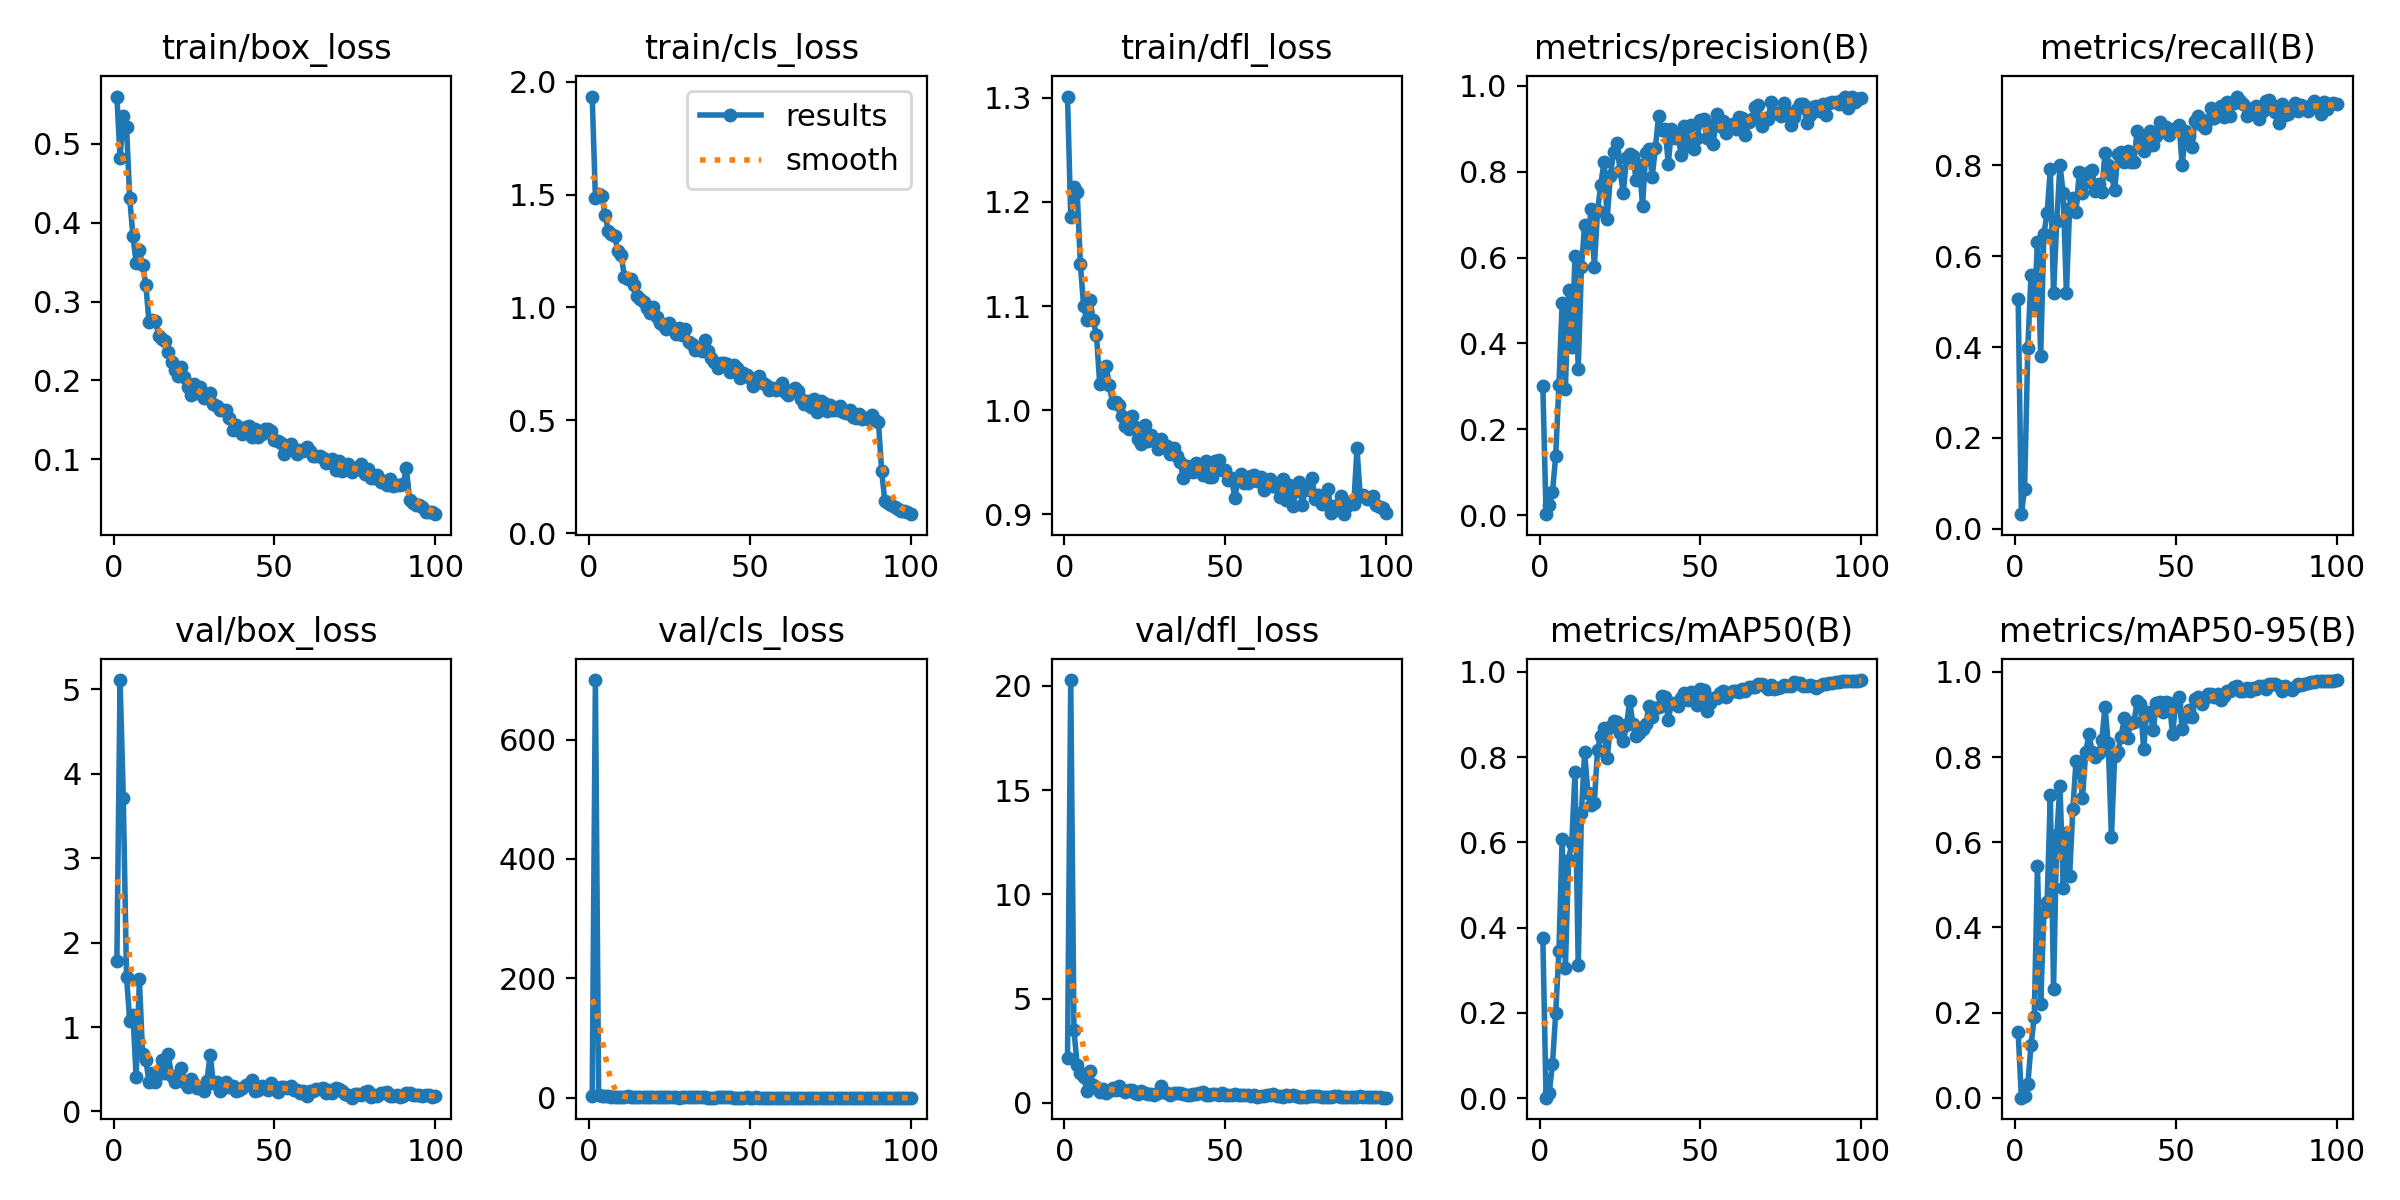

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/yolo11_results/pose_training2/results.png')

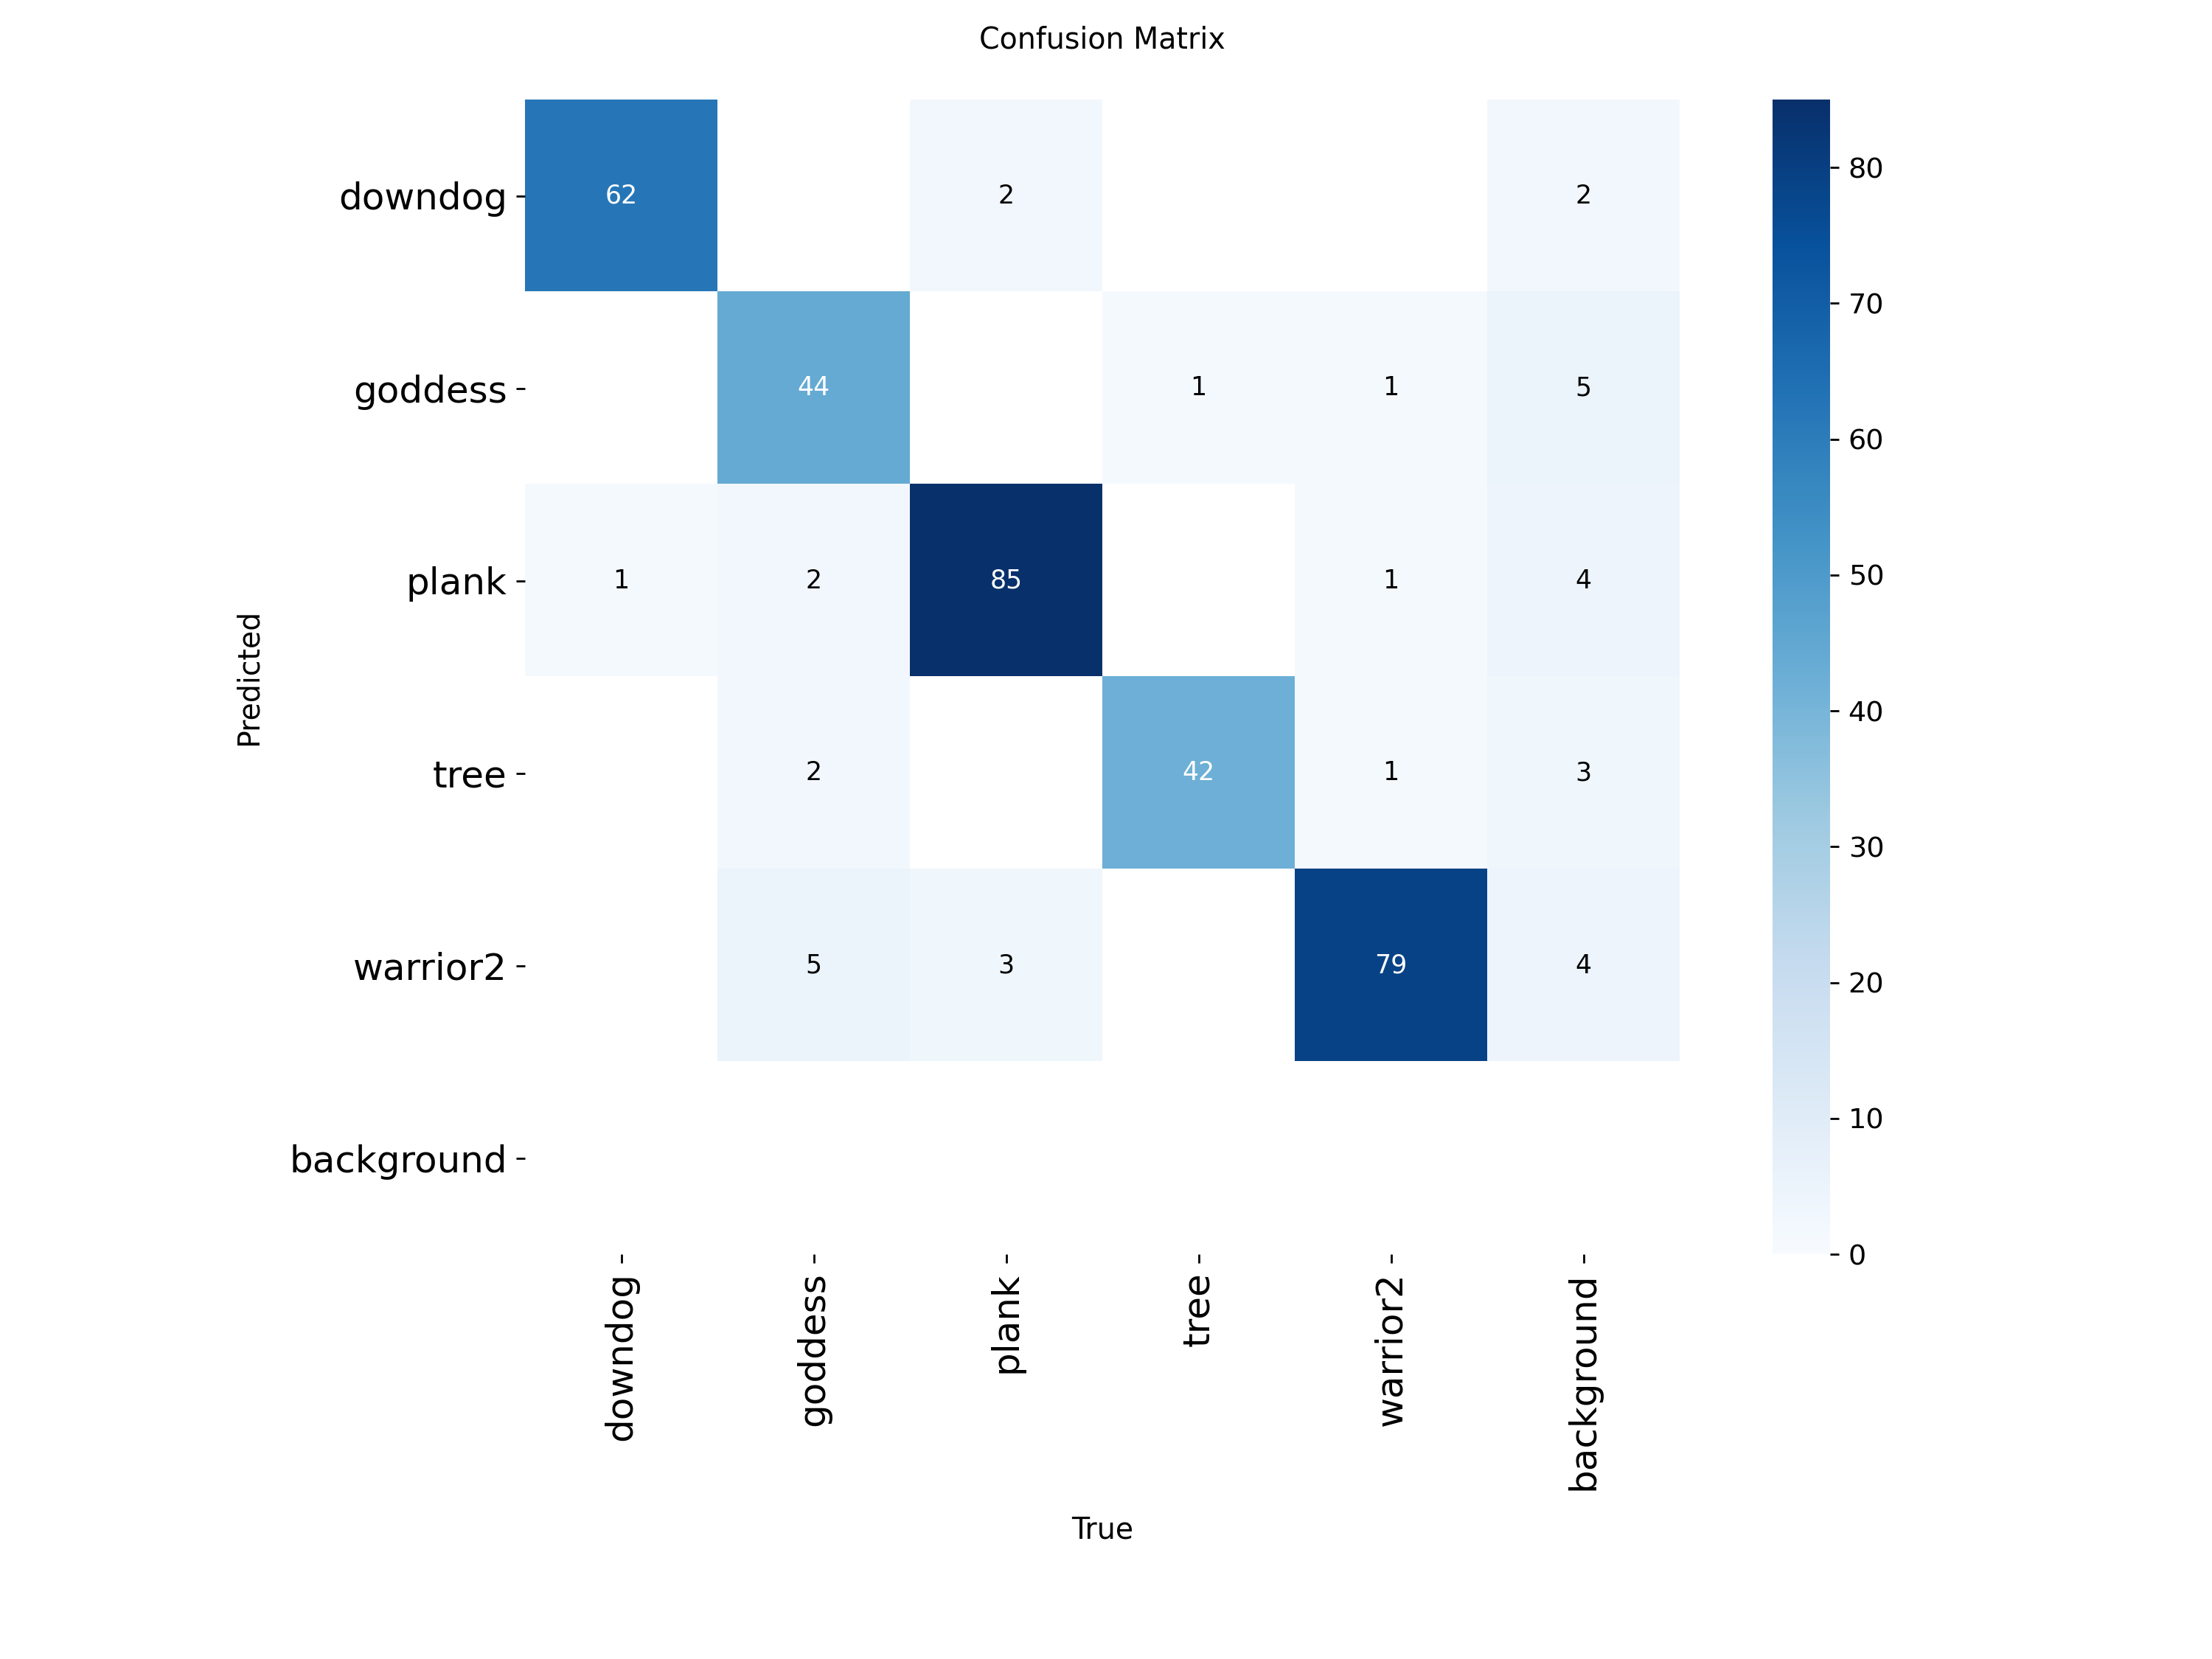

In [ ]:
Image(filename='/content/drive/MyDrive/yolo11_results/pose_training2/confusion_matrix.png')

## Load Trained Model & MediaPipe Setup

ไฟล์ [best.pt](https://drive.google.com/file/d/1wQBkCW7m0YEvtk7imZOCciUuwaiTaDWC/view?usp=sharing)

In [ ]:
model_classifier = YOLO('/content/drive/MyDrive/yolo11_results/pose_training2/weights/best.pt')

In [ ]:
mp_pose = mp.solutions.pose # ชี้ไปที่ Pose solution ของ Mediapipe

# สร้าง Pose object สำหรับตรวจจับท่าทาง
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) # ถ้า confidence < 0.5 จะไม่ถือว่าพบคน

# ˖⋆˚✿˖° Section 2: Define Thresholds

กำหนดค่า Threshold ของแต่ละท่าโดยอ้างอิงจากช่วงมุม (angle ranges) ที่พบในตัวอย่างท่าที่ทำถูกต้อง โดยนำข้อมูลท่าที่ถูกต้องมาวิเคราะห์ว่ามุมของแต่ละข้อต่อควรอยู่ในช่วงใด แล้วใช้ช่วงมุมนั้นเป็น Threshold สำหรับตรวจสอบความถูกต้องของท่า

In [ ]:
# Thresholds สำหรับแต่ละท่า (angle range in degrees)
POSE_ANGLE_THRESHOLDS = {
    # Tree Pose
    "tree_left": {   # ยกขาซ้าย
        "left_knee": (20, 60),     # ขาซ้ายงอ
        "right_knee": (160, 180),  # ขาขวาตรง
        "left_elbow": (150, 180),
        "right_elbow": (150, 180),
        "left_hip": (90, 130),
        "right_hip": (160, 180)
    },
    "tree_right": {  # ยกขาขวา
        "left_knee": (160, 180),
        "right_knee": (20, 60),
        "left_elbow": (150, 180),
        "right_elbow": (150, 180),
        "left_hip": (160, 180),
        "right_hip": (90, 130)
    },

    # Warrior II Pose
    "warrior2_left": {  # ขาซ้ายงอ
        "left_knee": (80, 110),
        "right_knee": (160, 180),
        "left_hip": (70, 125),
        "right_hip": (70, 125),
        "left_elbow": (160, 180),
        "right_elbow": (160, 180),
        "left_shoulder": (60, 120),
        "right_shoulder": (60, 120)
    },
    "warrior2_right": {  # ขาขวางอ
        "right_knee": (80, 110),
        "left_knee": (160, 180),
        "left_hip": (70, 125),
        "right_hip": (70, 125),
        "left_elbow": (160, 180),
        "right_elbow": (160, 180),
        "left_shoulder": (60, 120),
        "right_shoulder": (60, 120)
    },

    # Downward Dog
    "downdog": {
        "left_knee": (150, 180),
        "right_knee": (150, 180),
        "left_elbow": (145, 180),
        "right_elbow": (145, 180),
        "left_hip": (30, 110),
        "right_hip": (30, 110)
    },

    # Plank
    "plank": {
        "left_knee": (160, 180),
        "right_knee": (160, 180),
        "left_elbow": (160, 180),
        "right_elbow": (160, 180),
        "left_hip": (160, 180),
        "right_hip": (160, 180),
        "left_shoulder": (70, 110),
        "right_shoulder": (70, 110)
    },

    # Goddess
    "goddess": {
        "left_knee": (90, 130),
        "right_knee": (90, 130),
        "left_hip": (70, 120),
        "right_hip": (70, 120),
        "left_elbow": (40, 60),
        "right_elbow": (40, 60),
        "left_shoulder": (20, 50),
        "right_shoulder": (20, 50)
    }
}

# Feedback หากทำท่าผิด
JOINT_FEEDBACK_TEXT = {
    "left_knee": ("Raise your left knee slightly.", "Lower your left knee a bit."),
    "right_knee": ("Raise your right knee slightly.", "Lower your right knee a bit."),
    "left_elbow": ("Bend your left elbow a little more.", "Straighten your left elbow slightly."),
    "right_elbow": ("Bend your right elbow a little more.", "Straighten your right elbow slightly."),
    "left_hip": ("Lift your left hip slightly.", "Lower your left hip a bit."),
    "right_hip": ("Lift your right hip slightly.", "Lower your right hip a bit."),
    "left_shoulder": ("Raise your left shoulder slightly.", "Lower your left shoulder slightly."),
    "right_shoulder": ("Raise your right shoulder slightly.", "Lower your right shoulder slightly."),
}

# ˖⋆˚✿˖° Section 3: Angle Functions

ฟังก์ชัน `calculate_angle()`: ฟังก์ชันสำหรับ คำนวณมุมที่จุด b โดยจุด a และ c เป็นปลายของเส้นสองเส้นที่ประกอบกันเป็นมุมที่ b

In [ ]:
def calculate_angle(a, b, c):
    """
    คำนวณมุมที่ joint b
    a, b, c: tuple หรือ list ของ (x, y) coordinates
    return: angle (degree)
    """
    # แปลงพิกัดเป็น numpy array
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    # สร้างเวกเตอร์ BA และ BC
    ba = a - b
    bc = c - b

    # ใช้สูตร cosine หา cos(θ)
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0)) # ฟังก์ชัน arccos() ต้องรับค่าในช่วง -1 ถึง 1 คืนค่ามุมเป็น เรเดียน

    return np.degrees(angle) # แปลงเป็น องศา

**MediaPipes 33 keypoints**

ข้อมูลจาก: [
Google AI for Developers](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker)

<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=1RuTLplJa7xWLV12A3f_8xI4cMeKi-LGG" height="400">
</div>

ฟังก์ชัน `angles_finder()`: คำนวณมุมต่าง ๆ ของร่างกายจากโครงร่าง (pose landmarks) ที่ได้จาก MediaPipe
โดยมันจะคำนวณมุม 8 ตำแหน่ง ได้แก่
1. ข้อศอกซ้าย
1. ข้อศอกขวา
1. ไหล่ซ้าย
1. ไหล่ขวา
1. เข่าซ้าย
1. เข่าขวา
1. สะโพกซ้าย
1. สะโพกขวา

ภายในมีฟังก์ชันย่อย ได้แก่

* ฟังก์ชันย่อย `lm()`: แปลง normalized landmark -> pixel coordinate เพื่อเอาไปใช้คำนวณมุมใน `calculate_angle()`
    * ปกติ MediaPipe Pose ส่งค่า landmark แบบ normalized
    * lm.x อยู่ในช่วง 0 - 1
    * lm.y อยู่ในช่วง 0 - 1

landmark:
```
lm.x = 0.25
lm.y = 0.5
```
แปลงแล้ว:
```
x = 0.25 * 1280 = 320 px
y = 0.50 * 720  = 360 px
```

In [ ]:
def angles_finder(landmarks, img_width, img_height):
    """
    คำนวณมุมต่าง ๆ ของร่างกายจากโครงร่าง (pose landmarks) ที่ได้จาก MediaPipe
    return: angle (degree)
    """
    # ฟังก์ชันย่อยสำหรับแปลง normalized landmark -> pixel coordinate
    def lm(idx):
        lm = landmarks[idx]
        return (lm.x * img_width, lm.y * img_height)

    # มุมที่ ข้อศอกซ้าย
    left_elbow_angle = calculate_angle(lm(mp_pose.PoseLandmark.LEFT_SHOULDER.value), # หัวไหล่
                                      lm(mp_pose.PoseLandmark.LEFT_ELBOW.value), # ข้อศอก
                                      lm(mp_pose.PoseLandmark.LEFT_WRIST.value)) # ข้อมือ

    # มุมที่ ข้อศอกซ้ายขวา
    right_elbow_angle = calculate_angle(lm(mp_pose.PoseLandmark.RIGHT_SHOULDER.value), # หัวไหล่
                                       lm(mp_pose.PoseLandmark.RIGHT_ELBOW.value), # ข้อศอก
                                       lm(mp_pose.PoseLandmark.RIGHT_WRIST.value)) # ข้อมือ

    # มุมที่ ไหล่ซ้าย
    left_shoulder_angle = calculate_angle(lm(mp_pose.PoseLandmark.LEFT_ELBOW.value), # ข้อศอก
                                         lm(mp_pose.PoseLandmark.LEFT_SHOULDER.value), # หัวไหล่
                                         lm(mp_pose.PoseLandmark.LEFT_HIP.value)) # สะโพก

    # มุมที่ ไหล่ขวา
    right_shoulder_angle = calculate_angle(lm(mp_pose.PoseLandmark.RIGHT_HIP.value), # ข้อศอก
                                          lm(mp_pose.PoseLandmark.RIGHT_SHOULDER.value), # หัวไหล่
                                          lm(mp_pose.PoseLandmark.RIGHT_ELBOW.value)) # สะโพก

    # มุมที่ เข่าซ้าย
    left_knee_angle = calculate_angle(lm(mp_pose.PoseLandmark.LEFT_HIP.value), # สะโพก
                                     lm(mp_pose.PoseLandmark.LEFT_KNEE.value), # เข่า
                                     lm(mp_pose.PoseLandmark.LEFT_ANKLE.value)) # ข้อเท้า

    # มุมที่ เข่าขวา
    right_knee_angle = calculate_angle(lm(mp_pose.PoseLandmark.RIGHT_HIP.value), # สะโพก
                                      lm(mp_pose.PoseLandmark.RIGHT_KNEE.value), # เข่า
                                      lm(mp_pose.PoseLandmark.RIGHT_ANKLE.value)) # ข้อเท้า

    # มุมที่ สะโพกซ้าย
    left_hip_angle = calculate_angle(lm(mp_pose.PoseLandmark.LEFT_SHOULDER.value), # หัวไหล่
                                    lm(mp_pose.PoseLandmark.LEFT_HIP.value), # สะโพก
                                    lm(mp_pose.PoseLandmark.LEFT_KNEE.value)) # เข่า

    # มุมที่ สะโพกขวา
    right_hip_angle = calculate_angle(lm(mp_pose.PoseLandmark.RIGHT_SHOULDER.value), # หัวไหล่
                                    lm(mp_pose.PoseLandmark.RIGHT_HIP.value), # สะโพก
                                    lm(mp_pose.PoseLandmark.RIGHT_KNEE.value)) # เข่า

    return [left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle,left_hip_angle,right_hip_angle]

# ˖⋆˚✿˖° Section 4: Pose Analysis & Feedback

ฟังก์ชัน `detect_pose_side()`: ตรวจสอบ ด้านของท่าโยคะ (ซ้าย/ขวา) จากข้อมูลมุมข้อเข่า (joint_angles) และชื่อท่า (pose_name)

In [ ]:
def detect_pose_side(pose_name, joint_angles):
    """
    ตรวจสอบ ด้านของท่าโยคะ (ซ้าย/ขวา) จากข้อมูลมุมข้อเข่า (joint_angles) และชื่อท่า (pose_name)
    return: (pose_variant_name, detected_side) เช่น ("tree_left", "left") หรือ ("downdog", None)
    """
    pose_name = pose_name.lower()
    side = None
    mirrorable_poses = ["tree", "warrior2"] # รายชื่อท่าที่ สามารถมีด้านซ้าย/ขวาได้ เช่น tree pose, warrior 2 pose

    # ดึงค่ามุมข้อเข่าซ้ายและขวา ถ้าไม่มีข้อมูล คืนค่า None
    left_knee = joint_angles.get("left_knee", None)
    right_knee = joint_angles.get("right_knee", None)

    # ตรวจสอบว่าเป็นท่าที่มีด้านซ้าย/ขวา และมีข้อมูลเข่า
    if any(pose in pose_name for pose in mirrorable_poses) and left_knee is not None and right_knee is not None:

        # ตรวจสอบฝั่งที่ยืน ข้อเข่างอ (มุม < 120°) และ ข้อเข่าตรง (มุม > 140°)
        if left_knee < 120 and right_knee > 140:
            side = "left"
        elif right_knee < 120 and left_knee > 140:
            side = "right"

    if side:
        pose_variant = f"{pose_name.split('_')[0]}_{side}" # กำหนดชื่อท่าที่มีด้าน
    else:
        pose_variant = pose_name.split('_')[0]  # ใช้ชื่อพื้นฐาน เช่น plank หรือ downdog

    return pose_variant, side

ฟังก์ชัน `pose_feedback_structured()` ตรวจสอบท่าโยคะและมุมของข้อต่าง ๆ แล้วให้ feedback แบบ structured

In [ ]:
def pose_feedback_structured(pose_name, angles, joint_names):
    """
    ตรวจสอบท่าโยคะและมุมของข้อต่าง ๆ แล้วให้ feedback แบบ structured
    pose_name: ชื่อท่า เช่น "tree"
    angles: list ของมุมข้อ (float) ที่ได้จาก angles_finder()
    joint_names: list ของชื่อ joint ที่สอดคล้องกับ angles เช่น ["left_knee", "right_knee", ...]
    return: dict โครงสร้างแบบนี้ :
    {
      "pose_variant": str,
      "side": "left"|"right"|None,
      "joint_status": { "left_knee": {"status":"ok"/"low"/"high", "angle":90.0, "message": "..."} , ... },
      "summary": [ "Detected: Tree pose (LEFT side).", ... ]
    }
    """
    # สร้าง dict ของมุมจาก lists ที่เข้ามา
    joint_angles = {joint: angle for joint, angle in zip(joint_names, angles)}
    # ตรวจสอบด้านของท่า
    pose_variant, detected_side = detect_pose_side(pose_name, joint_angles)

    # สร้างโครงสร้างผลลัพธ์เริ่มต้น
    result = {
        "pose_variant": pose_variant,
        "side": detected_side,
        "joint_status": {},
        "summary": []
    }

    # ตรวจสอบว่ามี threshold ของ pose ใน POSE_ANGLE_THRESHOLDS ที่กำหนดไว้มั้ย
    if pose_variant not in POSE_ANGLE_THRESHOLDS:
        result["summary"].append(f"No threshold defined for pose: {pose_variant}")
        return result

    # ดึง thresholds ของ pose
    thresholds = POSE_ANGLE_THRESHOLDS[pose_variant]

    # ตรวจสอบมุมแต่ละ joint
    for joint in joint_names:
        angle = joint_angles.get(joint, None)

        if angle is None:
            # ไม่มีมุมสำหรับ joint นี้
            result["joint_status"][joint] = {
                "status": "missing",
                "angle": None,
                "message": "No angle available"
            }
            continue

        if joint not in thresholds:
            # joint นี้ไม่ได้ถูกใช้อ้างอิงใน thresholds ของ pose นี้
            result["joint_status"][joint] = {
                "status": "ignored",
                "angle": angle,
                "message": "Joint not checked for this pose"
            }
            continue

        # ดึง min_angle, max_angle ของ joint นั้น
        min_angle, max_angle = thresholds[joint]

        if angle < min_angle:
            # ต่ำเกินไป
            msg = JOINT_FEEDBACK_TEXT.get(joint, ("", ""))[0]  # คำแนะนำเมื่อมุมต่ำกว่า min
            result["joint_status"][joint] = {
                "status": "low",
                "angle": angle,
                "message": msg
            }
        elif angle > max_angle:
            # มากเกินไป
            msg = JOINT_FEEDBACK_TEXT.get(joint, ("", ""))[1]  # คำแนะนำเมื่อมุมเกิน max
            result["joint_status"][joint] = {
                "status": "high",
                "angle": angle,
                "message": msg
            }
        else:
            # อยู่ในช่วง min_angle, max_angle ที่กำหนด
            result["joint_status"][joint] = {
                "status": "ok",
                "angle": angle,
                "message": "OK"
            }

    # เพิ่มข้อความบอกว่า ตรวจพบท่าไหนและด้านไหน
    if detected_side:
        result["summary"].append(f"Detected: {pose_variant.replace('_',' ').title()} ({detected_side.upper()} side).")
    else:
        result["summary"].append(f"Detected: {pose_variant.title()} (no side detected).")

    # สร้าง list ของ joint ที่มุมไม่ถูกต้อง
    wrong = [j for j, v in result["joint_status"].items() if v["status"] in ("low", "high")]
    # เพิ่มข้อความบอกว่า ถูกต้องหรือมี joint ไหนผิด
    if not wrong:
        result["summary"].append("Great! Your pose looks correct.")
    else:
        result["summary"].append(f"Incorrect joints: {', '.join(wrong)}")

    return result

## Images

ฟังก์ชัน `prepare_img_for_pose()`สำหรับทำ preprocessing image ก่อนส่งเข้า MediaPipe Pose ทำการ Resize ให้สูงเท่า target ที่ตั้ง


In [ ]:
def prepare_img_for_pose(img, target_height=300):
    # ดึงขนาดภาพเดิม
    h, w = img.shape[:2]
    # คำนวณ scale เพื่อเอาไปใช้คำนวณให้ความสูงของภาพใหม่เท่ากับ target_height
    scale = target_height / h
    # คำนวณขนาดใหม่
    new_w, new_h = int(w*scale), int(h*scale)
    # Resize
    img_resized = cv2.resize(img, (new_w, new_h))

    return img_resized, scale

ฟังก์ชัน `analyze_pose_image()` เป็นฟังก์ชันหลักสำหรับ วิเคราะห์ท่าทาง (pose) จากภาพ และให้ feedback แบบ structured พร้อมวาด keypoints และ connections ของร่างกายบนภาพ

**pose_landmarks**
* ข้างในจะมี list ของ 33 จุด keypoints ตามมาตรฐาน Mediapipe Pose
* แต่ละ landmark มีค่า

```
landmark.x  # ตำแหน่ง x ในภาพ normalized (0.0 - 1.0)
landmark.y  # ตำแหน่ง y ในภาพ normalized (0.0 - 1.0)
landmark.z  # ตำแหน่ง z ในเชิงความลึก (negative คืออยู่หน้า)
landmark.visibility  # ความมั่นใจในการตรวจจับ (0.0 - 1.0)
```

In [ ]:
def analyze_pose_image(input_img, model_classifier, pose, angles_finder, show_feedback=True):
    # รับภาพ input
    if isinstance(input_img, str):
        # ตรวจสอบชนิดของ input_img ถ้าเป็น string
        img = cv2.imread(input_img)
        if img is None:
            raise ValueError(f"Cannot read image: {input_img}")
    elif isinstance(input_img, np.ndarray):
        # ตรวจสอบชนิดของ input_img ถ้าเป็น np.ndarray
        img = input_img.copy()
    else:
        raise ValueError("input_img must be a file path or a numpy array")

    # ตรวจจับ label (class) ของภาพ โดยใช้ model_classifier ที่ Train ไว้
    clf_results = model_classifier(img, verbose=False)
    # ถ้าเจอ object
    if len(clf_results[0].boxes) > 0:
        cls_id = int(clf_results[0].boxes.cls[0])
        label = clf_results[0].names[cls_id] # ดึงชื่อ label (class ท่าโยคะ)
    else:
        label = "unknown"

    # Resize ภาพ
    img_resized, scale = prepare_img_for_pose(img, target_height=300)
    # ตรวจจับ landmark ของร่างกาย จะได้ list ของ 33 จุด keypoints ตามมาตรฐาน Mediapipe Pose
    pose_results = pose.process(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)) # แปลง BGR เป็น RGB ตามที่ Mediapipe ต้องการก่อน

    # ถ้ามี landmarks คำนวณมุม joint
    if pose_results.pose_landmarks:
        landmarks = pose_results.pose_landmarks.landmark

        # ใช้ angles_finder คำนวณมุมของ joint ต่าง ๆ
        h, w, _ = img_resized.shape
        angles = angles_finder(landmarks, w, h)

        # ระบุ joint_names ที่จะตรวจ
        joint_names = [
            "left_elbow", "right_elbow", "left_shoulder", "right_shoulder",
            "left_knee", "right_knee", "left_hip", "right_hip"
        ]

        # สร้าง feedback structure
        result = pose_feedback_structured(label, angles, joint_names)

        # ตรวจสอบว่าทุก joint เป็น ignored/missing
        all_ignored = all(v["status"] in ("ignored", "missing") for v in result["joint_status"].values())

        # แสดง feedback text บน console ถ้า show_feedback=True
        if show_feedback:
            print("\nPose detected:", result["pose_variant"])

            # ถ้า joint ผิด แสดงชื่อ joint + status + message + angle
            wrong_joints = [j for j, v in result["joint_status"].items() if v["status"] in ("low", "high")]
            if wrong_joints:
                print("Incorrect joints feedback:")
                for joint in wrong_joints:
                    info = result["joint_status"][joint]
                    print(f"{joint}: {info['status']} - {info['message']} (angle={info['angle']:.2f})")
            # ถ้า all_ignored แสดงว่า pose ผิด
            elif all_ignored:
                print("Incorrect Pose")
            # ถ้าไม่มี joint ผิด แสดงว่า pose ถูกต้อง
            else:
                print("Great! Your pose looks correct.")

        # วาด keypoints บนภาพ
        mp_idx = { # mapping joint name กับ Mediapipe landmark index
            "left_shoulder": 11, "right_shoulder": 12,
            "left_elbow": 13, "right_elbow": 14,
            "left_wrist_back": 15, "right_wrist_back": 16,
            "left_hip": 23, "right_hip": 24,
            "left_knee": 25, "right_knee": 26,
            "left_ankle": 27, "right_ankle": 28
        }

        # จุด joint ที่มีปัญหา
        wrong_joints = {j for j, v in result["joint_status"].items() if v["status"] in ("low", "high")}

        # วนลูปวาดจุด joint
        for joint_name, idx in mp_idx.items():
            if idx >= len(landmarks):
                continue
            lm = landmarks[idx]
            # แปลง normalized coordinates เป็น pixel coordinates ด้วยขนาดภาพ w และ h
            cx, cy = int(lm.x * w), int(lm.y * h)

            # กำหนดสีของ joint
            if all_ignored:
                color = (0, 0, 255)  # สีแดง
            elif joint_name in wrong_joints:
                color = (0, 0, 255) # สีแดง
            elif result["joint_status"].get(joint_name, {}).get("status") == "ok":
                color = (0, 255, 0) # สีเขียว
            else:
                color = (255, 255, 255) # สีขาว

            # วาด circle ที่แต่ละ joint
            cv2.circle(img_resized, (cx, cy), 6, color, -1) # วาดวงกลมที่ joint
            info = result["joint_status"].get(joint_name, {})
            angle_text = f"{info.get('angle'):.0f}" if info.get('angle') is not None else "" # ดึงค่ามุมข้อ (angle) ถ้ามี
            cv2.putText(img_resized, f"{joint_name} {angle_text}", (cx+6, cy-6), # เขียนชื่อ joint และมุมบนภาพ
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

        # วาด connections (เส้นร่างกาย)
        body_connections = [
            (11, 12), (11, 13), (13, 15), (12, 14), (14, 16),
            (11, 23), (12, 24), (23, 24), (23, 25), (24, 26),
            (25, 27), (26, 28), (27, 31), (28, 32)
        ]

        # ใช้เพื่อดูชื่อ joint จาก index
        idx_to_joint = {v: k for k, v in mp_idx.items()}

        # วนลูปวาดเส้นทุกคู่ joint (a, b)
        for a, b in body_connections:
            # ข้ามคู่ที่ index เกินจำนวน landmarks
            if a >= len(landmarks) or b >= len(landmarks):
                continue
            # แปลง normalized coordinates (0-1) เป็น pixel (x, y)
            x0, y0 = int(landmarks[a].x * w), int(landmarks[a].y * h)
            x1, y1 = int(landmarks[b].x * w), int(landmarks[b].y * h)
            # ดึงชื่อ joint ของแต่ละ endpoint
            joint_a = idx_to_joint.get(a)
            joint_b = idx_to_joint.get(b)

            if all_ignored:
                color = (0, 0, 255) # สีแดง
            else:
                if (joint_a in wrong_joints) or (joint_b in wrong_joints):
                    color = (0, 0, 255) # สีแดง
                else:
                    color = (0, 255, 0) # สีเขียว

            # วาดเส้น ความหนา 2 px ระหว่าง joint a และ b
            cv2.line(img_resized, (x0, y0), (x1, y1), color, 2)

    return img_resized, result

### ᯓᰔ Result

ทดสอบกับท่าที่ปฏิบัติถูกต้อง


Pose detected: goddess
Great! Your pose looks correct.


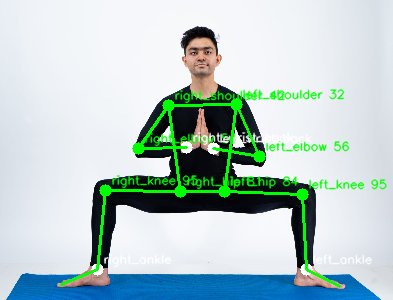

In [ ]:
img_out, feedback = analyze_pose_image("/content/goddess.jpg", model_classifier, pose, angles_finder)
cv2_imshow(img_out)

ทดสอบกับท่าที่ปฏิบัติไม่ถูกต้อง


Pose detected: goddess
Incorrect joints feedback:
right_knee: high - Lower your right knee a bit. (angle=136.94)
left_hip: high - Lower your left hip a bit. (angle=138.29)
right_hip: high - Lower your right hip a bit. (angle=141.81)


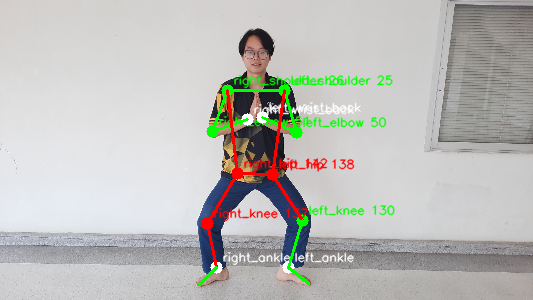

In [ ]:
img_out, feedback = analyze_pose_image("/content/goddess_incorrect.jpg", model_classifier, pose, angles_finder)
cv2_imshow(img_out)

พบข้อจำกัดในการจำแนกท่า: ท่า Downward Dog ที่ปฏิบัติไม่ถูกต้องมีลักษณะใกล้เคียงกับท่า Plank ในหลายมิติ ทำให้โมเดลบางครั้งทายผิดเป็นท่า Plank


Pose detected: plank
Incorrect joints feedback:
left_shoulder: high - Lower your left shoulder slightly. (angle=151.72)
right_shoulder: high - Lower your right shoulder slightly. (angle=148.08)
left_hip: low - Lift your left hip slightly. (angle=103.02)
right_hip: low - Lift your right hip slightly. (angle=102.58)


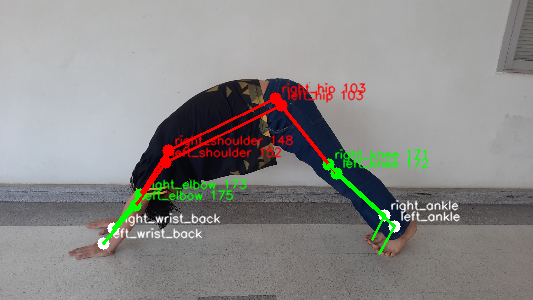

In [ ]:
img_out, feedback = analyze_pose_image("/content/downdog_incorrect.jpg", model_classifier, pose, angles_finder)
cv2_imshow(img_out)

ทดสอบกับท่าที่ปฏิบัติถูกต้องและท่าที่ปฏิบัติไม่ถูกต้องในแต่ละท่า

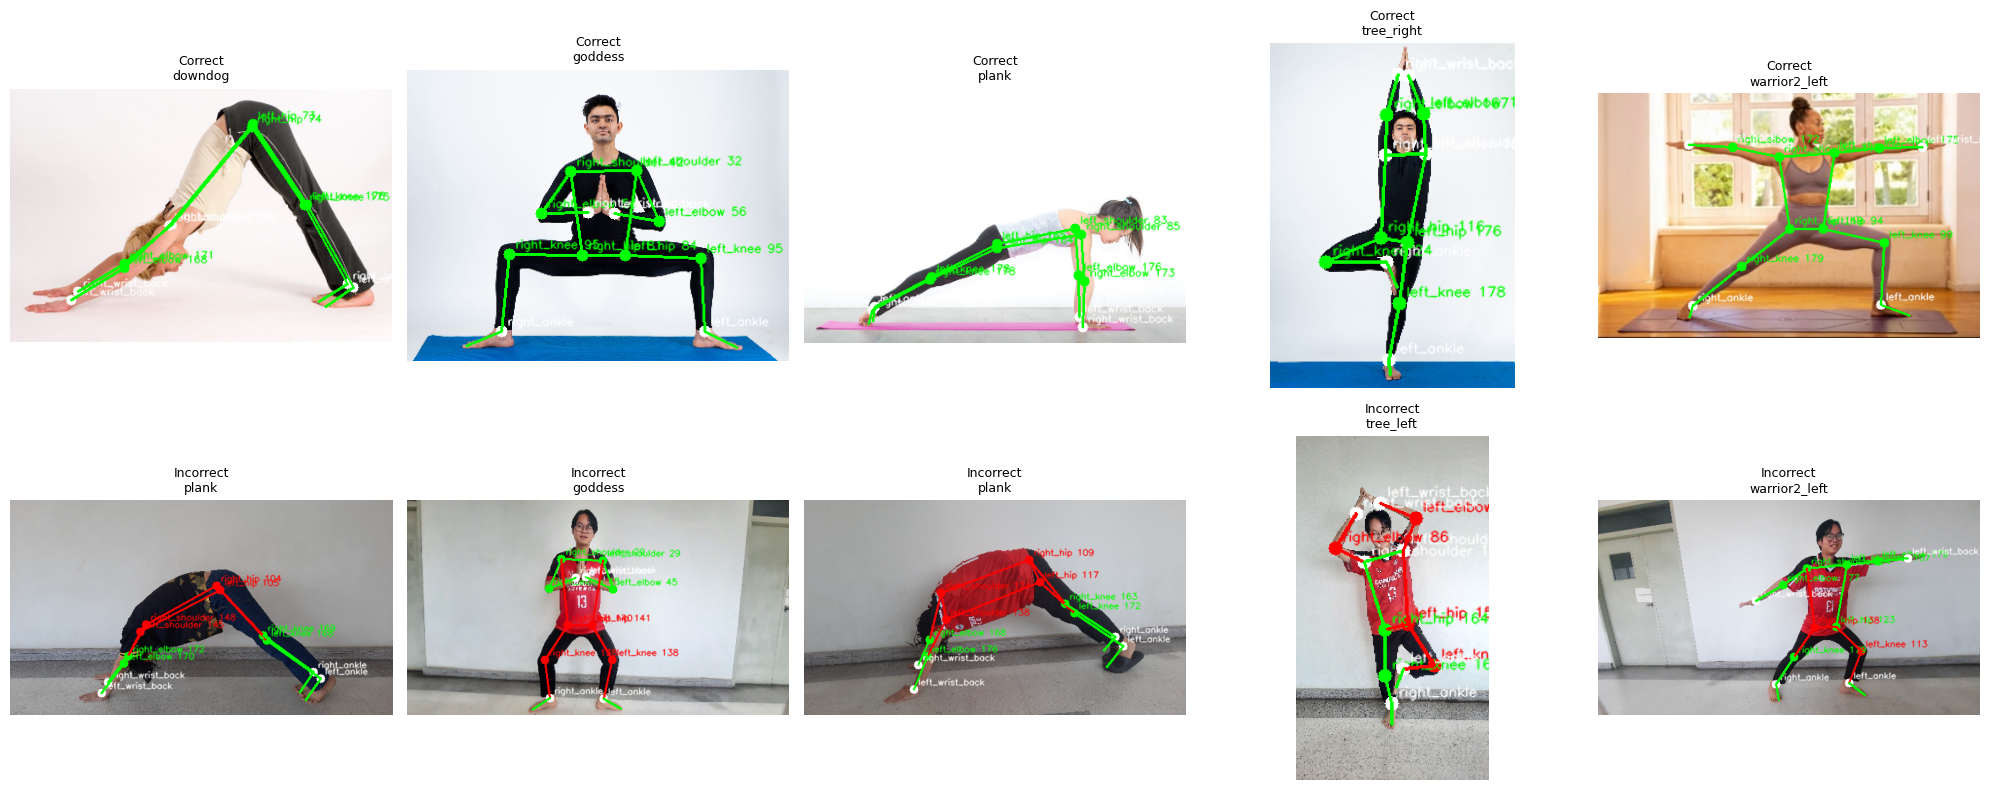

In [ ]:
correct_folder = "/content/drive/MyDrive/test_pose/correct"
incorrect_folder = "/content/drive/MyDrive/test_pose/incorrect"

image_files = sorted([f for f in os.listdir(correct_folder) if f.lower().endswith((".jpg", ".png"))])

plt.figure(figsize=(20, 8))

for i, filename in enumerate(image_files):
    correct_path = os.path.join(correct_folder, filename)
    incorrect_path = os.path.join(incorrect_folder, filename)

    # วิเคราะห์ correct
    img_correct, feedback_correct = analyze_pose_image(correct_path, model_classifier, pose, angles_finder, show_feedback=False)
    if img_correct is None:
        print(f"ไม่พบไฟล์ correct: {correct_path}")
        continue
    img_correct = cv2.cvtColor(img_correct, cv2.COLOR_BGR2RGB)

    # วิเคราะห์ incorrect
    img_incorrect, feedback_incorrect = analyze_pose_image(incorrect_path, model_classifier, pose, angles_finder, show_feedback=False)
    if img_incorrect is None:
        print(f"ไม่พบไฟล์ incorrect: {incorrect_path}")
        continue
    img_incorrect = cv2.cvtColor(img_incorrect, cv2.COLOR_BGR2RGB)

    # แสดง correct
    plt.subplot(2, len(image_files), i + 1)
    plt.imshow(img_correct)
    plt.axis("off")
    plt.title(f"Correct\n{feedback_correct["pose_variant"]}", fontsize=9)

    # แสดง incorrect
    plt.subplot(2, len(image_files), i + 1 + len(image_files))
    plt.imshow(img_incorrect)
    plt.axis("off")
    plt.title(f"Incorrect\n{feedback_incorrect["pose_variant"]}", fontsize=9)

plt.tight_layout()
plt.show()

## Video

In [ ]:
def analyze_pose_video(video_path, model_classifier, pose, angles_finder, output_path="/content/output_pose.mp4"):
    # อ่านวิดีโอ
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"ไม่สามารถเปิดวิดีโอ: {video_path}")
        return

    # ดึงข้อมูล video
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Processing video: {frame_count} frames at {fps} FPS")

    # สร้าง VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_written = 0

    # Loop ประมวลผลเฟรม
    for _ in tqdm(range(frame_count), desc="Processing"):
        ret, frame = cap.read()
        if not ret:
            break

        # เขียนเฟรมชั่วคราวและวิเคราะห์
        temp_frame_path = 'temp_frame.jpg'
        cv2.imwrite(temp_frame_path, frame)

        try:
            # เรียกใช้ analyze_pose_image() วิเคราะห์ pose ของเฟรม
            img_out, _ = analyze_pose_image(temp_frame_path, model_classifier, pose, angles_finder, show_feedback=False)

            # ถ้า img_out ไม่เป็น None
            if img_out is not None:
                if img_out.shape[1] != width or img_out.shape[0] != height:
                    img_out = cv2.resize(img_out, (width, height)) # ตรวจสอบขนาดเฟรม resize ให้ตรงกับวิดีโอเดิม
                out.write(img_out) # เขียนลง VideoWriter
                frame_written += 1
            else:
                # ถ้า img_out เป็น None เขียนเฟรมเดิม
                out.write(frame)
                frame_written += 1
        except Exception as e:
            # จัดการ Exception
            print(f"Error frame skipped: {e}")
            out.write(frame)
            frame_written += 1

    print(f"\nTotal frames written: {frame_written}")

    # ปิดทุกอย่าง
    cap.release()
    out.release()

    # ลบไฟล์ชั่วคราว
    if os.path.exists('temp_frame.jpg'):
        os.remove('temp_frame.jpg')

    # ตรวจสอบไฟล์
    if os.path.exists(output_path):
        print(f"\nVideo saved successfully at: {output_path}")
    else:
        print("\nFailed to save output video.")

### ᯓᰔ Result

In [ ]:
video_path = "/content/tree_vdo.mp4"

analyze_pose_video(video_path, model_classifier, pose, angles_finder, 'output_vdo_1.mp4')

Processing video: 190 frames at 30 FPS


Processing: 100%|██████████| 190/190 [00:19<00:00,  9.88it/s]


Total frames written: 190

Video saved successfully at: output_vdo_1.mp4


<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=1pK7D38vNybTOYjek8GLs8sT6WPmEGIJ7" height="400">
</div>

**เพิ่มเติม** ภาพแตกเนื่องจากเปลี่ยนเป็น gif ไฟล์

In [ ]:
video_path = "/content/goddess_vdo.mp4"

analyze_pose_video(video_path, model_classifier, pose, angles_finder, 'output_vdo_2.mp4')

Processing video: 175 frames at 30 FPS


Processing: 100%|██████████| 175/175 [00:17<00:00,  9.97it/s]


Total frames written: 175

Video saved successfully at: output_vdo_2.mp4


<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=1WRGpSBG3znK2g6IcrN3AzMLQ-f1mLcAW" height="400">
</div>